In [1]:
!nvidia-smi

Thu Apr 22 11:54:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.00540602days (467.08sec)


In [3]:
!git clone https://github.com/yours-schnee/custom_ImageNet.git

Cloning into 'custom_ImageNet'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 57 (delta 19), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [4]:
!pip install -e ./custom_ImageNet

ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /content/custom_ImageNet


In [5]:
import sys
sys.path.append('/content/custom_ImageNet')

import custom_ImageNet
from utils.ImageNetDataset import make_path_list
from utils.ImageNetDataset import str_convert
from utils.ImageNetDataset import ImageNetDataset

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [7]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data
import datetime

!pip install tensorboardX
import tensorboardX as tbx
from tensorboardX import SummaryWriter


     |████████████████████████████████| 122kB 8.7MB/s 


In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!cp "drive/My Drive/ImageNet/retina_10random_ImagenetTrain.zip" /content/
!cp "drive/My Drive/ImageNet/retina_original_ImagenetTest.zip" /content/

In [11]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [12]:
!7z x retina_10random_ImagenetTrain.zip
!mv "content/retina_ImagenetTrain" ../content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 2888291374 bytes (2755 MiB)

Extracting archive: retina_10random_ImagenetTrain.zip
  2% 4096 Open              --
Path = retina_10random_ImagenetTrain.zip
Type = zip
Physical Size = 2888291374
64-bit = +

  0%      0% 545 - content/retina_ImagenetTrain/pineapple/pineapple_3582.jpg                                                                      0% 942          0% 1262 - content/retina_ImagenetTrain/pineapple/pineapple_3368.jpg                                  

In [13]:
!7z x retina_original_ImagenetTest.zip
!mv "content/retina_ImagenetTest" ../content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 34489251 bytes (33 MiB)

Extracting archive: retina_original_ImagenetTest.zip
--
Path = retina_original_ImagenetTest.zip
Type = zip
Physical Size = 34489251

  0%     38% 795 - content/retina_ImagenetTest/elephant/elephant_030.jpg                                                                 77% 1573 - content/retina_ImagenetTest/bear/bear_039.jpg                                                         Everything is Ok

Folders: 21
Files: 2000
Size:       34552399
Comp

In [14]:
import shutil

directory = 'content'

try:
    shutil.rmtree(directory)
except FileNotFoundError:
    pass

In [15]:
rootpathTrain ='retina_ImagenetTrain/'
rootpathTest ='retina_ImagenetTest/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list(rootpathTest)

In [16]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [17]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
classes_list = train_dataset.get_label_relation()

batch_size = 32

In [18]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [19]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [20]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

141568

In [21]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


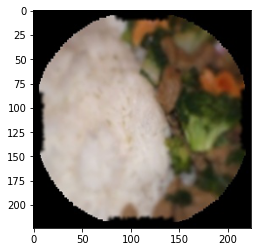

In [22]:
index = 2
imges, label = train_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [23]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [24]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [25]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

In [26]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):
    
    log_path = F"/content/drive/My Drive/Colab Notebooks/Log/"
    now = datetime.datetime.now()
    folder = F"{name}"+now.strftime('%Y%m%d_%H%M%S')

    writer = tbx.SummaryWriter(log_path+folder)

    global best_accuracy;
    global training_losses; global val_losses;
    global train_accuracies; global val_accuracies;
    global epochs;
    global stats;
    train_loss=0; val_loss=0; train_acc=0; val_acc=0; 
    for epoch in range(epochs,num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_acc = 0       # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_acc += preds.eq(labels.view_as(preds)).sum().item()

            #print(epoch_acc)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_acc / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_loss=epoch_loss; train_acc=epoch_acc;
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_loss=epoch_loss; val_acc=epoch_acc;

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)
                    
                    total_name = name+".tar"
                    path = F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"
                    torch.save({"best_model":model.state_dict(),
                                "best_acc":best_accuracy
                                },path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if epoch%2==0:
            # Colab's disconnection timing while saving data might cause the broken save data against our hope.
            # So, results every epochs will be saved every epochs.
            
            total_name = name+"_epoch"+str(epoch)+".tar"

            path = F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"
            torch.save({
                "epoch":epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss":training_losses,
                "val_loss":val_losses,
                "train_acc":train_accuracies,
                "val_acc":val_accuracies
                }, path)
            
        print('-------------')
        writer.add_scalars('/loss', {'train_loss': train_loss,
                                     'val_loss': val_loss
                                    }, epoch)
      
        writer.add_scalars('/acc', {'train_acc': train_acc,
                                    'val_acc': val_acc
                                    }, epoch)

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

### CONST data

In [36]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 10
else:
    NUM_EPOCS = 70

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

### Network model

In [37]:
# Load pre-trained VGG-16
use_pretrained = True
net = models.mobilenet_v2(pretrained=use_pretrained)

# Replacement last layer output for 20 classes
net.classifier[1] = nn.Linear(in_features=1280, out_features=N_CLASSES)

net.cuda()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

### Loss function

In [38]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### Optimization method

In [39]:
# Optimization setting
optimizer = optim.SGD(net.parameters(), lr=0.008, momentum=0.9)

In [40]:
LOAD_STATE = True
EPOCH = 50             # This values need to check the latest tar ffile name with epoch.
name = "05_3_mobilenet"
folder_name = "mobilenet"

if LOAD_STATE:
    stats=[];
    PATH1 =  F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{name}.tar"

    checkpoint = torch.load(PATH1)
    best_model = net
    best_model.load_state_dict( checkpoint["best_model"] )
    best_accuracy = 0#checkpoint["best_acc"]

    # Colab's disconnection timing while saving data might cause the broken save data against our hope.
    # So, results every epochs will be saved every epochs.
    total_name = name+"_epoch"+str(EPOCH)+".tar"
    PATH2 =  F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"

    checkpoint = torch.load(PATH2)
    epochs = checkpoint["epoch"]
    net.load_state_dict( checkpoint["model_state_dict"] )
    optimizer.load_state_dict( checkpoint["optimizer_state_dict"] )
    training_losses = checkpoint["train_loss"]; val_losses = checkpoint["val_loss"];
    train_accuracies = checkpoint["train_acc"]; val_accuracies = checkpoint["val_acc"];
    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

else:
    # start point
    best_model=net;
    best_accuracy = 0;
    training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    stats=[];
    epochs=0;


In [41]:
best_model, stats = train_model(net, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 51/70
-------------



train Loss: 0.0006 Acc: 99.4059



val Loss: 0.0063 Acc: 95.2532
-------------
Epoch 52/70
-------------



train Loss: 0.0005 Acc: 99.4335



val Loss: 0.0074 Acc: 94.4112
-------------
Epoch 53/70
-------------



train Loss: 0.0006 Acc: 99.3417



val Loss: 0.0065 Acc: 95.0243
-------------
Epoch 54/70
-------------



train Loss: 0.0006 Acc: 99.3530



val Loss: 0.0066 Acc: 95.1514
-------------
Epoch 55/70
-------------



train Loss: 0.0006 Acc: 99.4264



val Loss: 0.0064 Acc: 95.4396
-------------
Epoch 56/70
-------------



train Loss: 0.0006 Acc: 99.4208



val Loss: 0.0064 Acc: 95.2475
-------------
Epoch 57/70
-------------



train Loss: 0.0005 Acc: 99.4596



val Loss: 0.0063 Acc: 95.3125
-------------
Epoch 58/70
-------------



train Loss: 0.0005 Acc: 99.4575



val Loss: 0.0066 Acc: 95.2334
-------------
Epoch 59/70
-------------



train Loss: 0.0005 Acc: 99.5161



val Loss: 0.0066 Acc: 95.4368
-------------
Epoch 60/70
-------------



train Loss: 0.0005 Acc: 99.4596



val Loss: 0.0062 Acc: 95.4820
-------------
Epoch 61/70
-------------



train Loss: 0.0005 Acc: 99.4236



val Loss: 0.0073 Acc: 94.7898
-------------
Epoch 62/70
-------------



train Loss: 0.0006 Acc: 99.3607



val Loss: 0.0061 Acc: 95.3210
-------------
Epoch 63/70
-------------



train Loss: 0.0004 Acc: 99.5465



val Loss: 0.0063 Acc: 95.3944
-------------
Epoch 64/70
-------------



train Loss: 0.0004 Acc: 99.5522



val Loss: 0.0062 Acc: 95.6290
-------------
Epoch 65/70
-------------



train Loss: 0.0004 Acc: 99.5310



val Loss: 0.0071 Acc: 94.9989
-------------
Epoch 66/70
-------------



train Loss: 0.0004 Acc: 99.5345



val Loss: 0.0063 Acc: 95.5611
-------------
Epoch 67/70
-------------



train Loss: 0.0004 Acc: 99.5373



val Loss: 0.0062 Acc: 95.6855
-------------
Epoch 68/70
-------------



train Loss: 0.0004 Acc: 99.6299



val Loss: 0.0068 Acc: 95.1684
-------------
Epoch 69/70
-------------



train Loss: 0.0005 Acc: 99.5281



val Loss: 0.0067 Acc: 95.2249
-------------
Epoch 70/70
-------------



train Loss: 0.0004 Acc: 99.6150



val Loss: 0.0064 Acc: 95.5611
-------------
Lowest training loss 0.00035242866042079103
Lowest validation loss 0.006102630904888676
Highest training accuracy 99.62985985533453
Highest validation accuracy 95.68546564195299
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/05_3_mobilenet_Loss _.png05_3_mobilenet_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/05_3_mobilenet_Accuracy _.png05_3_mobilenet_Accuracy _.png


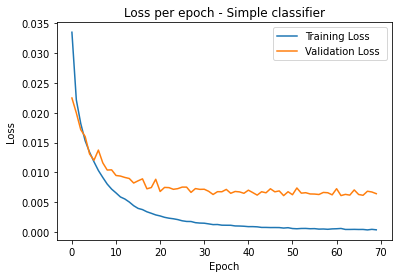

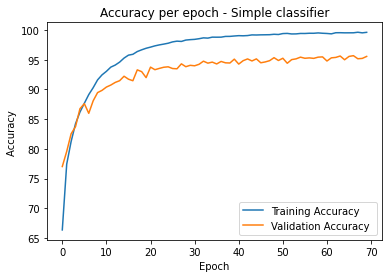

In [44]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],70,"Loss ",name)
plot_graph(stats[1],stats[3],70,"Accuracy ",name)


Test loss: 1.5881 
Testing Accuracy: 1563/2000 (78.15%)
apple Class Accuracy: 62/100 (62.00%)
banana Class Accuracy: 89/100 (89.00%)
bear Class Accuracy: 87/100 (87.00%)
bell_pepper Class Accuracy: 70/100 (70.00%)
bird Class Accuracy: 77/100 (77.00%)
broccoli Class Accuracy: 79/100 (79.00%)
cat Class Accuracy: 70/100 (70.00%)
cauliflower Class Accuracy: 76/100 (76.00%)
cow Class Accuracy: 90/100 (90.00%)
dog Class Accuracy: 61/100 (61.00%)
elephant Class Accuracy: 90/100 (90.00%)
fox Class Accuracy: 83/100 (83.00%)
goat Class Accuracy: 68/100 (68.00%)
horse Class Accuracy: 77/100 (77.00%)
mashed_potato Class Accuracy: 82/100 (82.00%)
orange Class Accuracy: 86/100 (86.00%)
pineapple Class Accuracy: 80/100 (80.00%)
pomegranate Class Accuracy: 80/100 (80.00%)
tomato Class Accuracy: 73/100 (73.00%)
zebra Class Accuracy: 83/100 (83.00%)
Classifier has Acc=0.781 P=0.782 R=0.785 F1=0.781
               precision    recall  f1-score   support

        apple       0.70      0.62      0.66     

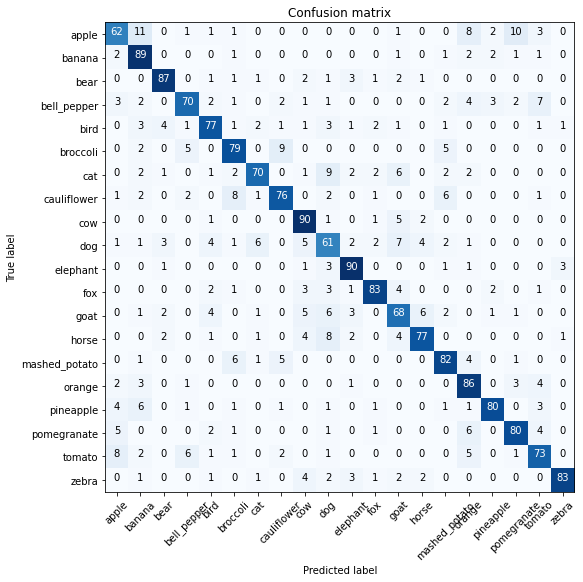

In [45]:
result = test_model(best_model, criterion, name)

In [32]:
best_model, stats = train_model(net, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 31/50
-------------



train Loss: 0.0015 Acc: 98.4318



val Loss: 0.0072 Acc: 93.9845
-------------
Epoch 32/50
-------------



train Loss: 0.0014 Acc: 98.5406



val Loss: 0.0068 Acc: 94.2332
-------------
Epoch 33/50
-------------



train Loss: 0.0012 Acc: 98.6840



val Loss: 0.0063 Acc: 94.7615
-------------
Epoch 34/50
-------------



train Loss: 0.0013 Acc: 98.6416



val Loss: 0.0068 Acc: 94.4281
-------------
Epoch 35/50
-------------



train Loss: 0.0011 Acc: 98.8041



val Loss: 0.0068 Acc: 94.6033
-------------
Epoch 36/50
-------------



train Loss: 0.0011 Acc: 98.7963



val Loss: 0.0071 Acc: 94.2953
-------------
Epoch 37/50
-------------



train Loss: 0.0011 Acc: 98.8034



val Loss: 0.0065 Acc: 94.7135
-------------
Epoch 38/50
-------------



train Loss: 0.0010 Acc: 98.9277



val Loss: 0.0068 Acc: 94.4818
-------------
Epoch 39/50
-------------



train Loss: 0.0010 Acc: 98.9334



val Loss: 0.0067 Acc: 94.4535
-------------
Epoch 40/50
-------------



train Loss: 0.0010 Acc: 98.9984



val Loss: 0.0065 Acc: 95.1034
-------------
Epoch 41/50
-------------



train Loss: 0.0009 Acc: 99.0549



val Loss: 0.0070 Acc: 94.2699
-------------
Epoch 42/50
-------------



train Loss: 0.0009 Acc: 99.0323



val Loss: 0.0066 Acc: 94.8435
-------------
Epoch 43/50
-------------



train Loss: 0.0009 Acc: 99.0718



val Loss: 0.0062 Acc: 95.1401
-------------
Epoch 44/50
-------------



train Loss: 0.0008 Acc: 99.1820



val Loss: 0.0068 Acc: 94.7983
-------------
Epoch 45/50
-------------



train Loss: 0.0008 Acc: 99.1665



val Loss: 0.0066 Acc: 95.1458
-------------
Epoch 46/50
-------------



train Loss: 0.0007 Acc: 99.1926



val Loss: 0.0073 Acc: 94.4903
-------------
Epoch 47/50
-------------



train Loss: 0.0008 Acc: 99.2032



val Loss: 0.0067 Acc: 94.6316
-------------
Epoch 48/50
-------------



train Loss: 0.0007 Acc: 99.2159



val Loss: 0.0069 Acc: 94.8435
-------------
Epoch 49/50
-------------



train Loss: 0.0007 Acc: 99.2873



val Loss: 0.0061 Acc: 95.3492
-------------
Epoch 50/50
-------------



train Loss: 0.0007 Acc: 99.2498



val Loss: 0.0068 Acc: 94.8745
-------------
Lowest training loss 0.0006639875153392256
Lowest validation loss 0.006102630904888676
Highest training accuracy 99.28726830922243
Highest validation accuracy 95.3492314647378
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/05_3_mobilenet_Loss _.png05_3_mobilenet_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/05_3_mobilenet_Accuracy _.png05_3_mobilenet_Accuracy _.png


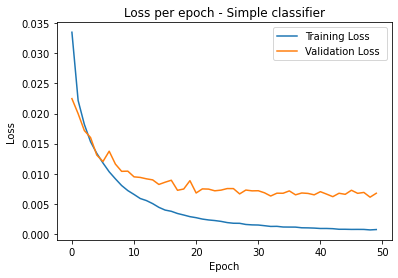

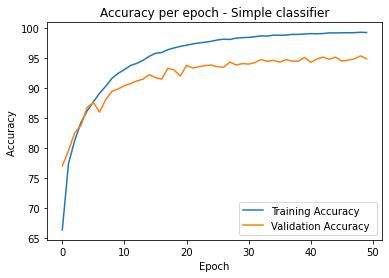

In [34]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],50,"Loss ",name)
plot_graph(stats[1],stats[3],50,"Accuracy ",name)


Test loss: 1.4715 
Testing Accuracy: 1555/2000 (77.75%)
apple Class Accuracy: 67/100 (67.00%)
banana Class Accuracy: 75/100 (75.00%)
bear Class Accuracy: 88/100 (88.00%)
bell_pepper Class Accuracy: 77/100 (77.00%)
bird Class Accuracy: 77/100 (77.00%)
broccoli Class Accuracy: 78/100 (78.00%)
cat Class Accuracy: 67/100 (67.00%)
cauliflower Class Accuracy: 79/100 (79.00%)
cow Class Accuracy: 87/100 (87.00%)
dog Class Accuracy: 56/100 (56.00%)
elephant Class Accuracy: 83/100 (83.00%)
fox Class Accuracy: 75/100 (75.00%)
goat Class Accuracy: 76/100 (76.00%)
horse Class Accuracy: 79/100 (79.00%)
mashed_potato Class Accuracy: 81/100 (81.00%)
orange Class Accuracy: 83/100 (83.00%)
pineapple Class Accuracy: 76/100 (76.00%)
pomegranate Class Accuracy: 80/100 (80.00%)
tomato Class Accuracy: 82/100 (82.00%)
zebra Class Accuracy: 89/100 (89.00%)
Classifier has Acc=0.777 P=0.778 R=0.782 F1=0.778
               precision    recall  f1-score   support

        apple       0.71      0.67      0.69     

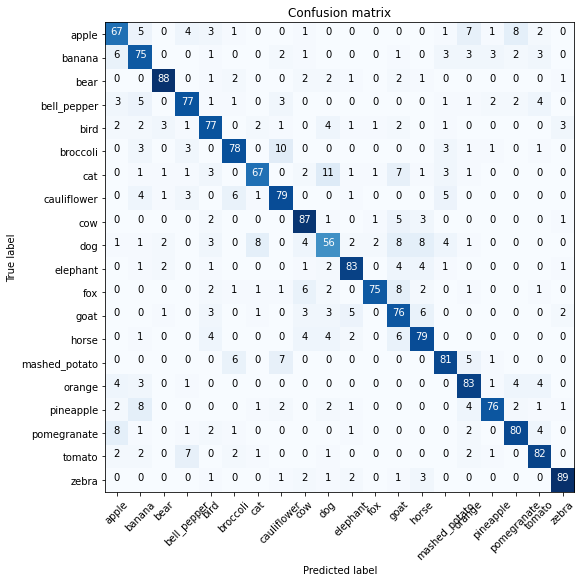

In [35]:
result = test_model(best_model, criterion, name)

### intermediate result (1)

In [ ]:
best_model, stats = train_model(net, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 1/30
-------------



train Loss: 0.0335 Acc: 66.3625



val Loss: 0.0225 Acc: 77.0287
-------------
Epoch 2/30
-------------



train Loss: 0.0222 Acc: 77.4264



val Loss: 0.0200 Acc: 79.5688
-------------
Epoch 3/30
-------------



train Loss: 0.0182 Acc: 81.2387



val Loss: 0.0172 Acc: 82.5384
-------------
Epoch 4/30
-------------



train Loss: 0.0153 Acc: 84.2373



val Loss: 0.0160 Acc: 83.7449
-------------
Epoch 5/30
-------------



train Loss: 0.0134 Acc: 86.1833



val Loss: 0.0131 Acc: 86.7541
-------------
Epoch 6/30
-------------



train Loss: 0.0118 Acc: 87.6780



val Loss: 0.0120 Acc: 87.6074
-------------
Epoch 7/30
-------------



train Loss: 0.0103 Acc: 89.1367



val Loss: 0.0137 Acc: 85.9827
-------------
Epoch 8/30
-------------



train Loss: 0.0091 Acc: 90.2965



val Loss: 0.0116 Acc: 88.0905
-------------
Epoch 9/30
-------------



train Loss: 0.0080 Acc: 91.6111



val Loss: 0.0104 Acc: 89.4722
-------------
Epoch 10/30
-------------



train Loss: 0.0072 Acc: 92.4517



val Loss: 0.0104 Acc: 89.8452
-------------
Epoch 11/30
-------------



train Loss: 0.0066 Acc: 93.0507



val Loss: 0.0095 Acc: 90.4046
-------------
Epoch 12/30
-------------



train Loss: 0.0059 Acc: 93.7599



val Loss: 0.0094 Acc: 90.7437
-------------
Epoch 13/30
-------------



train Loss: 0.0055 Acc: 94.1053



val Loss: 0.0091 Acc: 91.1844
-------------
Epoch 14/30
-------------



train Loss: 0.0050 Acc: 94.6040



val Loss: 0.0090 Acc: 91.4755
-------------
Epoch 15/30
-------------



train Loss: 0.0044 Acc: 95.2821



val Loss: 0.0082 Acc: 92.2271
-------------
Epoch 16/30
-------------



train Loss: 0.0040 Acc: 95.7745



val Loss: 0.0086 Acc: 91.7298
-------------
Epoch 17/30
-------------



train Loss: 0.0038 Acc: 95.9179



val Loss: 0.0089 Acc: 91.4698
-------------
Epoch 18/30
-------------



train Loss: 0.0034 Acc: 96.3812



val Loss: 0.0072 Acc: 93.2979
-------------
Epoch 19/30
-------------



train Loss: 0.0031 Acc: 96.6730



val Loss: 0.0075 Acc: 92.9956
-------------
Epoch 20/30
-------------



train Loss: 0.0029 Acc: 96.9329



val Loss: 0.0088 Acc: 91.9897
-------------
Epoch 21/30
-------------



train Loss: 0.0027 Acc: 97.1265



val Loss: 0.0068 Acc: 93.7585
-------------
Epoch 22/30
-------------



train Loss: 0.0025 Acc: 97.3377



val Loss: 0.0075 Acc: 93.3262
-------------
Epoch 23/30
-------------



train Loss: 0.0023 Acc: 97.5008



val Loss: 0.0074 Acc: 93.5437
-------------
Epoch 24/30
-------------



train Loss: 0.0022 Acc: 97.6344



val Loss: 0.0072 Acc: 93.7387
-------------
Epoch 25/30
-------------



train Loss: 0.0021 Acc: 97.7813



val Loss: 0.0073 Acc: 93.8122
-------------
Epoch 26/30
-------------



train Loss: 0.0019 Acc: 98.0066



val Loss: 0.0075 Acc: 93.5240
-------------
Epoch 27/30
-------------



train Loss: 0.0018 Acc: 98.1302



val Loss: 0.0075 Acc: 93.4788
-------------
Epoch 28/30
-------------



train Loss: 0.0018 Acc: 98.0836



val Loss: 0.0066 Acc: 94.3123
-------------
Epoch 29/30
-------------



train Loss: 0.0016 Acc: 98.3125



val Loss: 0.0073 Acc: 93.8319
-------------
Epoch 30/30
-------------



train Loss: 0.0015 Acc: 98.3831



val Loss: 0.0072 Acc: 94.0636
-------------
Lowest training loss 0.0015005897130487389
Lowest validation loss 0.006645075609182491
Highest training accuracy 98.38310917721519
Highest validation accuracy 94.312273960217
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/05_3_mobilenet_Loss _.png05_3_mobilenet_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/05_3_mobilenet_Accuracy _.png05_3_mobilenet_Accuracy _.png


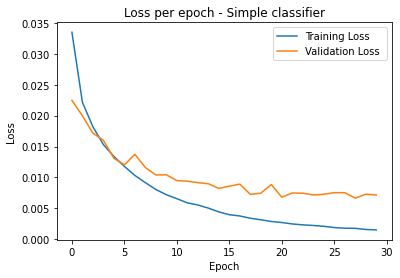

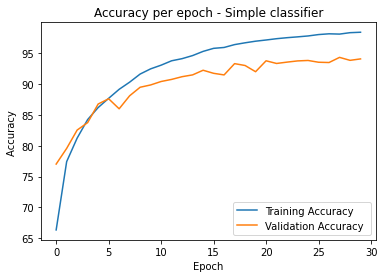

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 1.2799 
Testing Accuracy: 1525/2000 (76.25%)
apple Class Accuracy: 67/100 (67.00%)
banana Class Accuracy: 81/100 (81.00%)
bear Class Accuracy: 87/100 (87.00%)
bell_pepper Class Accuracy: 72/100 (72.00%)
bird Class Accuracy: 76/100 (76.00%)
broccoli Class Accuracy: 70/100 (70.00%)
cat Class Accuracy: 64/100 (64.00%)
cauliflower Class Accuracy: 75/100 (75.00%)
cow Class Accuracy: 89/100 (89.00%)
dog Class Accuracy: 56/100 (56.00%)
elephant Class Accuracy: 90/100 (90.00%)
fox Class Accuracy: 79/100 (79.00%)
goat Class Accuracy: 60/100 (60.00%)
horse Class Accuracy: 70/100 (70.00%)
mashed_potato Class Accuracy: 86/100 (86.00%)
orange Class Accuracy: 79/100 (79.00%)
pineapple Class Accuracy: 82/100 (82.00%)
pomegranate Class Accuracy: 74/100 (74.00%)
tomato Class Accuracy: 79/100 (79.00%)
zebra Class Accuracy: 89/100 (89.00%)
Classifier has Acc=0.762 P=0.763 R=0.765 F1=0.762
               precision    recall  f1-score   support

        apple       0.67      0.67      0.67     

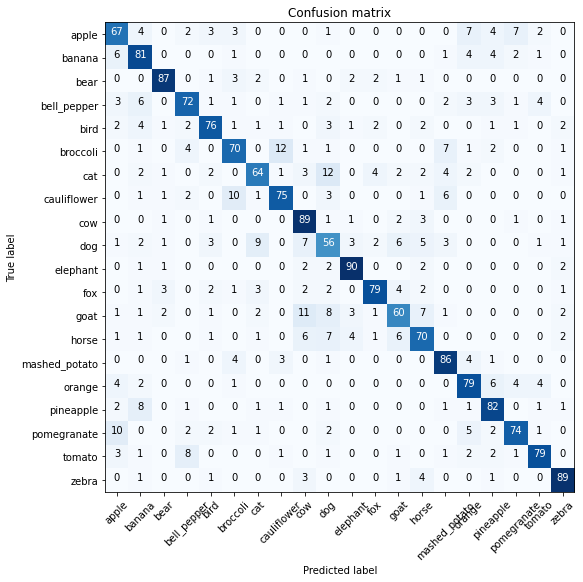

In [ ]:
result = test_model(best_model, criterion, name)